In [7]:
import os
import re
import math
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.attention.flex_attention import flex_attention, create_block_mask
import triton
import triton.language as tl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
from einops import rearrange, repeat, reduce
# import lovely_tensors as lt; lt.monkey_patch() # INTRODUCE GRAPH BREAK!

torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
torch.set_float32_matmul_precision('high')
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

USE_SDPA = False
USE_TORCH_COMPILE = False

device

device(type='cuda')

# Data Prep

In [1]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs.txt', 'r', encoding='latin') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39526018


In [2]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [3]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 86 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|


In [5]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '\x94': 85, '': 86}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=

In [8]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39526018])

In [9]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [11]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130757]) torch.Size([395261])


In [12]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [13]:
def get_batch(split, seq_len, batch_size=4, n_future_tokens=1):
    data = train_data if split == 'train' else val_data
    max_start_index = len(data) - seq_len - n_future_tokens
    ix = torch.randint(max_start_index, (batch_size,))
    # --- Vectorized Indexing ---
    # Instead of looping, we compute all indices at once.

    # 1. Create indices for the input sequences `x`.
    # `t_range` creates the offsets for each token in a sequence [0, 1, ..., seq_len-1]
    t_range = torch.arange(seq_len)
    # Use broadcasting to create a grid of indices for the entire batch.
    # `ix.unsqueeze(1)` has shape (batch_size, 1)
    # `t_range` has shape (seq_len)
    # The result `x_indices` has shape (batch_size, seq_len)
    x_indices = ix.unsqueeze(1) + t_range

    # 2. Create indices for the target sequences `y`.
    # `f_range` creates offsets for the future tokens [0, 1, ..., n_future_tokens-1]
    f_range = torch.arange(n_future_tokens)
    # We build upon `x_indices` to get the target indices.
    # `x_indices.unsqueeze(2)` has shape (batch_size, seq_len, 1)
    # `f_range` has shape (n_future_tokens)
    # Broadcasting creates `y_indices` with shape (batch_size, seq_len, n_future_tokens)
    # Each y_indices[b, t, :] corresponds to the targets for input x[b, t].
    y_indices = x_indices.unsqueeze(2) + f_range + 1

    x = data[x_indices]
    y = data[y_indices]
    y = y.transpose(1, 2)

    if n_future_tokens == 1:
        y = y.squeeze(1)

    x = x.unsqueeze(1)
    # print(f"{x.shape = }, {y.shape = }")
    x = torch.concat([x, y], dim=1)
    x = x[:, :-1, :]
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2, 3)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 3, 64])
tensor([[[62, 71, 77,  1, 59, 58, 60, 68,  1, 80, 66, 77, 65,  1, 65, 66, 76,  1, 70, 72, 70,  1, 77, 72,  1, 65, 66, 76,  1, 73, 58, 75, 62, 71, 77, 76,  3,  1, 65, 72, 78, 76, 62, 10,  0,  0, 29, 76,  1, 63, 72, 75,  1, 48, 72, 61, 72, 75, 72, 68, 66,  8,  1, 80],
         [71, 77,  1, 59, 58, 60, 68,  1, 80, 66, 77, 65,  1, 65, 66, 76,  1, 70, 72, 70,  1, 77, 72,  1, 65, 66, 76,  1, 73, 58, 75, 62, 71, 77, 76,  3,  1, 65, 72, 78, 76, 62, 10,  0,  0, 29, 76,  1, 63, 72, 75,  1, 48, 72, 61, 72, 75, 72, 68, 66,  8,  1, 80, 65],
         [77,  1, 59, 58, 60, 68,  1, 80, 66, 77, 65,  1, 65, 66, 76,  1, 70, 72, 70,  1, 77, 72,  1, 65, 66, 76,  1, 73, 58, 75, 62, 71, 77, 76,  3,  1, 65, 72, 78, 76, 62, 10,  0,  0, 29, 76,  1, 63, 72, 75,  1, 48, 72, 61, 72, 75, 72, 68, 66,  8,  1, 80, 65, 72]],

        [[58, 75, 62,  1, 66, 71, 79, 78, 69, 71, 62, 75, 58, 59, 69, 62,  2,  0,  0, 51, 65, 62, 75, 62,  1, 61, 66, 61,  1, 77, 65, 62, 82,  1, 61, 66, 76, 58, 73, 

# Training Prep

In [14]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 5000
seq_len = 256
batch_size = 256 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

327680000

In [15]:
def train(model, optimizer, seq_len, batch_size, total_steps, val_steps=10, val_interval=50, n_future_tokens=1):
    losses = []
    val_losses = []
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    for steps in (bar := tqdm(range(total_steps))):  # increase number of steps for good results...
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size, n_future_tokens=n_future_tokens)

        # evaluate the loss
        logits, loss = model(xb, yb)

        # backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}")
        losses.append(loss.item())
        if steps % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size, n_future_tokens=n_future_tokens)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(1, 4)
            ax.legend()
            dh.update(fig)
    print('final loss:', loss.item(), 'final val loss:', val_loss)

In [16]:
# Measure post training perplexity on validation set
# Create function that receives a model, context length, and PPL sequence length, and returns the perplexity
# The PPL sequence length is the number of characters the function uses to calculate the perplexity
# We take the logits and calculate the cross entropy loss from scratch, then exponentiate it to get the perplexity
# not only that, but we want the models to do this in actual inference
def perplexity(model, seq_len, ppl_seq_len, batch_size=128, val_steps=1000):
    with torch.no_grad():
        val_loss = 0
        for _ in tqdm(range(val_steps)):
            xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits, _ = model(xb, yb)
            logits = logits.reshape(batch_size, seq_len, vocab_size)
            logits = logits[:, :ppl_seq_len]
            yb = yb[:, :ppl_seq_len]
            # flatten logits and targets
            logits = logits.reshape(batch_size*ppl_seq_len, vocab_size)
            yb = yb.reshape(batch_size*ppl_seq_len)
            # calculate cross entropy loss from scratch
            loss = F.cross_entropy(logits, yb)
            val_loss += loss.item()
        val_loss /= val_steps
        ppl = torch.exp(torch.tensor(val_loss))
        return ppl.item(), val_loss

# Transformers

## Classic Transformer

In [15]:
class TransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == xq_.ndim - 2 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == xq_.ndim - 2 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2] 
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(xq.dim() - 1)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(xq.dim() - 1)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention with AliBi in parallel """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        # block_mask for FlexAttention
        def causal(b, h, q_idx, kv_idx):
            causal_mask = q_idx >= kv_idx
            return causal_mask
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        _, _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        # Split into heads
        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])

        if T == self.seq_len:
            out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) # (B, H, 1, C/H) @ (B, H, C/H, T) -> (B, H, 1, T)
            wei = wei * self.head_size ** -0.5 # scaled attention
            wei = wei.masked_fill(self.tril[T_k-T:T_k, T_k-T:T_k] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1) # (B, H, T, T)
            # apply attention to values
            out = wei @ v # (B, H, 1, T) @ (B, H, T, C/H) -> (B, H, 1, C/H)

        out = out.transpose(1, 2).contiguous().view(B, T, C) # (B, H, T, C/H) -> (B, T, H, C/H) -> (B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num)])

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.shape
        _, _, T_past, _ = kv_cache[0][0].shape if kv_cache is not None and kv_cache[0][0] is not None else (0, 0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,V)
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [(None, None) for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [16]:
# Test forward pass
config = TransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6
)
m = TransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

4775511

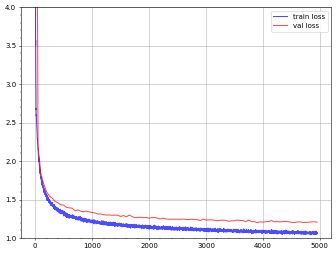

  0%|          | 0/5000 [00:00<?, ?it/s]

/erland-home/Python_project/transformers_playground/.venv/lib/python3.12/site-packages/torch/_inductor/lowering.py:1917: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


final loss: 1.0691111087799072 final val loss: 1.2072466731071472


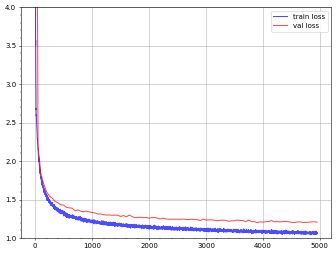

In [17]:
# training!
model = TransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [19]:
# Save
torch.save(model.state_dict(), 'models/TransformerLM.pt')

In [20]:
# Load model
model = TransformerLM(config)
model = torch.compile(model)
model.load_state_dict(torch.load('models/TransformerLM.pt'))
model.to(device)

OptimizedModule(
  (_orig_mod): TransformerLM(
    (token_embedding_table): Embedding(87, 256)
    (lm_head): Linear(in_features=256, out_features=87, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
          (query): Linear(in_features=256, out_features=256, bias=False)
          (value): Linear(in_features=256, out_features=256, bias=False)
          (o): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff_layer): FeedForward(
          (lin_1): Linear(in_features=256, out_features=1024, bias=True)
          (lin_2): Linear(in_features=1024, out_features=256, bias=True)
          (relu): ReLU()
        )
        (sa_norm): RMSNorm()
        (ff_norm): RMSNorm()
      )
    )
  )
)

In [21]:
# calculate perplexity
ppl, loss = perplexity(model, seq_len, seq_len)
print("perplexity:", ppl, "loss:", loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

perplexity: 3.3366286754608154 loss: 1.2049609375


In [22]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])


You will never do that!

If you can be saying that the rest of us will be to save us...

I can't forgive you because you came to see me.

I'm sure you'll be a pretty good friend with me.

I thought I was the only one who dreamed of me.

I'd like to ask you this time.

The book is a fantasy side that you're pretty surprised.

If you have no idea what you want to tell me.

I mean, you should think of my own life.

It feels so surprised.

It was all a drink.

Should I tell you to stop stopping the magic power once you're done.

I don't want to go out with you.

You're really a mistake.

What are you talking about?

I have a talk about what I said would think.

I saw you will wear the top out of the magic of the magic words.

Why don't you try to stop me with that face?

I was always to be a coincidence.

In the magic case, I tried to stop you.

I was worried about you all about that proper thing.

I was thinking about working at the first step toward the story.

I can see that I felt like

## MTP

In [ ]:
class MTPTransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.n_future_tokens = n_future_tokens

@torch.compiler.disable
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

@torch.compiler.disable
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == xq_.ndim - 2 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == xq_.ndim - 2 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2] 
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(xq.dim() - 1)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(xq.dim() - 1)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention with AliBi in parallel """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        # block_mask for FlexAttention
        def causal(b, h, q_idx, kv_idx):
            causal_mask = q_idx >= kv_idx
            return causal_mask
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        _, _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        # Split into heads
        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])

        if T == self.seq_len:
            out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) # (B, H, 1, C/H) @ (B, H, C/H, T) -> (B, H, 1, T)
            wei = wei * self.head_size ** -0.5 # scaled attention
            wei = wei.masked_fill(self.tril[T_k-T:T_k, T_k-T:T_k] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1) # (B, H, T, T)
            # apply attention to values
            out = wei @ v # (B, H, 1, T) @ (B, H, T, C/H) -> (B, H, 1, C/H)

        out = out.transpose(1, 2).contiguous().view(B, T, C) # (B, H, T, C/H) -> (B, T, H, C/H) -> (B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class MTPTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        self.n_future_tokens = config.n_future_tokens
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num - self.n_future_tokens)])
        self.extra_heads = nn.ModuleList([Block(config) for _ in range(self.n_future_tokens)])

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads=False):
        B, T = idx.shape
        _, _, T_past, _ = kv_cache[0][0].shape if kv_cache is not None and kv_cache[0][0] is not None else (0, 0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer

        # MTP
        trunk = x # (B,T,C)

        latents = []
        n_heads_to_use = self.n_future_tokens if return_all_heads else 1
        prediction_heads = [self.blocks[-1]] + list(self.extra_heads)

        for i, block in enumerate(prediction_heads[:n_heads_to_use]):
            x, cache = block(x, None if kv_cache is None else kv_cache[i + self.layer_num - self.n_future_tokens])
            if kv_cache is not None:
                kv_cache[i + self.layer_num - self.n_future_tokens] = cache
            latents.append(x)

        x = torch.stack(latents, dim=-2) # (B, T, n_heads_to_use, C)

        all_logits = self.lm_head(x) # (B, T, n_heads_to_use, V)
        
        if targets is None:
            loss = None
        else:
            B, T, n_heads_to_use, V = all_logits.shape
            logits_flat = all_logits.view(-1, V)
            targets_flat = targets.reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)

        logits = all_logits if return_all_heads else all_logits[:, :, 0, :] # Return the first head only
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [(None, None) for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [16]:
# Test forward pass
n_future_tokens = 1
config = MTPTransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6,
    n_future_tokens=n_future_tokens
)
m = MTPTransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1, n_future_tokens)
logits, loss = m(xb, yb, return_all_heads=True)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

4775511

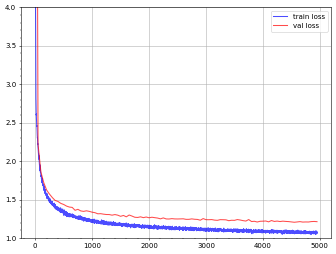

  0%|          | 0/5000 [00:00<?, ?it/s]

final loss: 1.0742982625961304 final val loss: 1.213886284828186


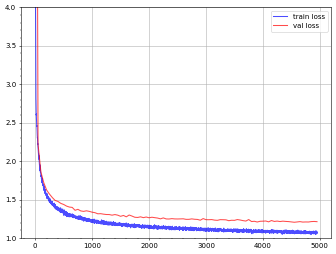

In [17]:
# training!
model = MTPTransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [18]:
# Save
torch.save(model.state_dict(), 'models/MTPTransformerLM.pt')

In [19]:
# Load model
model = MTPTransformerLM(config)
model = torch.compile(model)
model.load_state_dict(torch.load('models/MTPTransformerLM.pt'))
model.to(device)

OptimizedModule(
  (_orig_mod): MTPTransformerLM(
    (token_embedding_table): Embedding(87, 256)
    (lm_head): Linear(in_features=256, out_features=87, bias=True)
    (blocks): ModuleList(
      (0-4): 5 x Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
          (query): Linear(in_features=256, out_features=256, bias=False)
          (value): Linear(in_features=256, out_features=256, bias=False)
          (o): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff_layer): FeedForward(
          (lin_1): Linear(in_features=256, out_features=1024, bias=True)
          (lin_2): Linear(in_features=1024, out_features=256, bias=True)
          (relu): ReLU()
        )
        (sa_norm): RMSNorm()
        (ff_norm): RMSNorm()
      )
    )
    (extra_heads): ModuleList(
      (0): Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
    

In [20]:
# calculate perplexity
ppl, loss = perplexity(model, seq_len, seq_len)
print("perplexity:", ppl, "loss:", loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

perplexity: 3.348928928375244 loss: 1.208640625


In [32]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never be sold by your friends and worked out.

Why are they here?

I won't let you try to survive the new land.

You don't need to be the one who was a bit stronger than that?

I won't be able to do that.

Why don't you come to see that to help you?

I think that I thought I was able to be that bad at the captain of the ground.

I can't treat you to the control of the Secrets will be the worst position of the first place.

I wonder if it can't be a total power to see the Secret of the Sea God.

But I don't think that I want to see it on a day.

The Secret said that we want to show the problem here.

He said that he looked in a relationship with him at the first time on the same time.

Allow us to have to do is think of it, control of the main station.

The Secret is a mistake.

The Sea God of Tenkaidou is a man or something else in the stars of the dead face.

It's a perfect rest for the Soul Reaper

of the Sou

## Saving Memory MTP

In [15]:
class MTPTransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.n_future_tokens = n_future_tokens

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)

@torch.compiler.disable
def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # Reshape freqs_cis for broadcasting
    shape = [1] * (xq_.ndim - 2) + list(freqs_cis.shape)
    freqs_cis = freqs_cis.view(*shape)

    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        
        def causal(b, h, q_idx, kv_idx):
            return q_idx >= kv_idx
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])
        
        if T == self.seq_len and self.causal_mask is not None:
             out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            wei = q @ k.transpose(-2,-1) * (self.head_size**-0.5)
            wei = wei.masked_fill(self.tril[:T, :T_k] == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)
            out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)

    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache

# ---- NEW: Custom Autograd Function for MEMORY-EFFICIENT TRAINING ----

class SequentialHeadsCustomBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, trunk_output, lm_head, *prediction_heads):
        # Save modules and non-tensor arguments for the backward pass.
        ctx.prediction_heads = prediction_heads
        ctx.lm_head = lm_head
        # Save tensors needed for the backward pass.
        ctx.save_for_backward(trunk_output)

        # Standard sequential forward pass
        latents = []
        for head in prediction_heads:
            latent, _ = head(trunk_output, kv_cache=None)
            latents.append(latent)
        
        latents_stacked = torch.stack(latents, dim=-2)
        all_logits = lm_head(latents_stacked)
        return all_logits

    @staticmethod
    def backward(ctx, grad_output):
        trunk_output, = ctx.saved_tensors
        prediction_heads = ctx.prediction_heads
        lm_head = ctx.lm_head
        
        d = trunk_output.detach().requires_grad_(True)
        grad_output_per_head = grad_output.unbind(dim=2)

        for i, head in enumerate(prediction_heads):
            with torch.enable_grad():
                head_latent, _ = head(d)
                head_logits = lm_head(head_latent)
            
            head_logits.backward(gradient=grad_output_per_head[i])
            
        num_nones = 1 + len(prediction_heads) # For lm_head + *prediction_heads
        return (d.grad,) + (None,) * num_nones

# ---- REFACTORED MTPTransformerLM with custom backward logic ----

class MTPTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        
        # Clean separation between trunk and heads
        num_trunk_blocks = config.layer_num - config.n_future_tokens
        self.trunk_blocks = nn.ModuleList([Block(config) for _ in range(num_trunk_blocks)])
        self.prediction_heads = nn.ModuleList([Block(config) for _ in range(config.n_future_tokens)])

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads=False, use_custom_backward=True):
        B, T = idx.shape
        tok_embd = self.token_embedding_table(idx)
        x = tok_embd
        
        # 1. Shared Trunk
        for i, block in enumerate(self.trunk_blocks):
            x, _ = block(x) # Simplified kv_cache for clarity
        trunk = x

        # 2. Prediction Heads
        n_heads_to_use = self.config.n_future_tokens if return_all_heads else 1
        
        if self.training and return_all_heads and use_custom_backward:
            # Pass only the heads we intend to use to the custom function
            active_heads = self.prediction_heads[:n_heads_to_use]
            all_logits = SequentialHeadsCustomBackward.apply(trunk, self.lm_head, *active_heads)
        else:
            latents = []
            for i, block in enumerate(self.prediction_heads[:n_heads_to_use]):
                x_head, _ = block(trunk)
                latents.append(x_head)
            x = torch.stack(latents, dim=-2)
            all_logits = self.lm_head(x)
        
        # 3. Loss Calculation
        loss = None
        if targets is not None:
            B, T, H, V = all_logits.shape
            logits_flat = all_logits.view(B * T * H, V)
            targets_flat = targets.reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)

        logits = all_logits if return_all_heads else all_logits.squeeze(2)
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.seq_len else idx[:, -self.config.seq_len:]
            # Note: generate calls with return_all_heads=False, so it doesn't use the custom BWD path
            logits, _ = self(idx_cond, return_all_heads=False)
            logits = logits[:, -1, :] / temperature if temperature > 0 else logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [16]:
# Test forward pass
n_future_tokens = 3
config = MTPTransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6,
    n_future_tokens=n_future_tokens
)
m = MTPTransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1, n_future_tokens)
logits, loss = m(xb, yb, return_all_heads=True)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

4775511

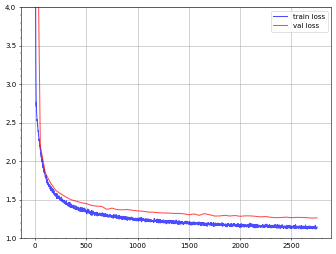

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# training!
model = MTPTransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# Save
torch.save(model.state_dict(), 'models/SavingMemoryMTPTransformerLM.pt')

In [ ]:
# Load model
model = MTPTransformerLM(config)
model = torch.compile(model)
model.load_state_dict(torch.load('models/SavingMemoryMTPTransformerLM.pt'))
model.to(device)

OptimizedModule(
  (_orig_mod): MTPTransformerLM(
    (token_embedding_table): Embedding(87, 256)
    (lm_head): Linear(in_features=256, out_features=87, bias=True)
    (blocks): ModuleList(
      (0-4): 5 x Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
          (query): Linear(in_features=256, out_features=256, bias=False)
          (value): Linear(in_features=256, out_features=256, bias=False)
          (o): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff_layer): FeedForward(
          (lin_1): Linear(in_features=256, out_features=1024, bias=True)
          (lin_2): Linear(in_features=1024, out_features=256, bias=True)
          (relu): ReLU()
        )
        (sa_norm): RMSNorm()
        (ff_norm): RMSNorm()
      )
    )
    (extra_heads): ModuleList(
      (0): Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
    

In [ ]:
# calculate perplexity
ppl, loss = perplexity(model, seq_len, seq_len)
print("perplexity:", ppl, "loss:", loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

perplexity: 3.348928928375244 loss: 1.208640625


In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never be sold by your friends and worked out.

Why are they here?

I won't let you try to survive the new land.

You don't need to be the one who was a bit stronger than that?

I won't be able to do that.

Why don't you come to see that to help you?

I think that I thought I was able to be that bad at the captain of the ground.

I can't treat you to the control of the Secrets will be the worst position of the first place.

I wonder if it can't be a total power to see the Secret of the Sea God.

But I don't think that I want to see it on a day.

The Secret said that we want to show the problem here.

He said that he looked in a relationship with him at the first time on the same time.

Allow us to have to do is think of it, control of the main station.

The Secret is a mistake.

The Sea God of Tenkaidou is a man or something else in the stars of the dead face.

It's a perfect rest for the Soul Reaper

of the Sou

# Investigate Saving Memory

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import copy


class DSMTPTransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.n_future_tokens = n_future_tokens

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)

@torch.compiler.disable
def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # Reshape freqs_cis for broadcasting
    shape = [1] * (xq_.ndim - 2) + list(freqs_cis.shape)
    freqs_cis = freqs_cis.view(*shape)

    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        
        def causal(b, h, q_idx, kv_idx):
            return q_idx >= kv_idx
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])
        
        if T == self.seq_len:
             out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            wei = q @ k.transpose(-2,-1) * (self.head_size**-0.5)
            wei = wei.masked_fill(self.tril[:T, :T_k] == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)
            out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)

    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache

class DSMTPTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num - config.n_future_tokens)])
        self.extra_heads = nn.ModuleList([Block(config) for _ in range(config.n_future_tokens)])

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads=False, use_custom_backward=True):
        B, T = idx.shape
        tok_embd = self.token_embedding_table(idx)
        x = tok_embd
        
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])
        trunk = x

        n_heads_to_use = self.config.n_future_tokens if return_all_heads else 1
        prediction_heads = [self.blocks[-1]] + list(self.extra_heads) if len(self.blocks) > 0 else list(self.extra_heads)

        if self.training and return_all_heads and use_custom_backward:
            all_logits = SequentialHeadsCustomBackward.apply(trunk, self.lm_head, *prediction_heads[:n_heads_to_use])
        else:
            latents = []
            for i, block in enumerate(prediction_heads[:n_heads_to_use]):
                x_head, _ = block(trunk)
                latents.append(x_head)
            x = torch.stack(latents, dim=-2)
            all_logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, V = all_logits.shape[0], all_logits.shape[1], all_logits.shape[-1]
            logits_flat = all_logits.view(B * T * n_heads_to_use, V)
            targets_flat = targets.reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)

        logits = all_logits if return_all_heads else all_logits[:, :, 0, :]
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        # This function remains largely the same, as it calls forward with return_all_heads=False
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.seq_len else idx[:, -self.config.seq_len:]
            logits, _ = self(idx_cond, return_all_heads=False)
            logits = logits[:, -1, :] / temperature if temperature > 0 else logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# DeepSeek MTP

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import copy

# targets: [B, n_future_tokens, S]

class DSMTPTransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.n_future_tokens = n_future_tokens

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)

@torch.compiler.disable
def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # Reshape freqs_cis for broadcasting
    shape = [1] * (xq_.ndim - 2) + list(freqs_cis.shape)
    freqs_cis = freqs_cis.view(*shape)

    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        
        def causal(b, h, q_idx, kv_idx):
            return q_idx >= kv_idx
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])
        
        if T == self.seq_len:
             out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            wei = q @ k.transpose(-2,-1) * (self.head_size**-0.5)
            wei = wei.masked_fill(self.tril[:T, :T_k] == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)
            out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)

    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache

class DSMTPTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        
        # The main body of the model
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num - config.n_future_tokens)])
        # The prediction heads that branch off
        self.extra_heads = nn.ModuleList([Block(config) for _ in range(config.n_future_tokens)])
        self.projection_head = nn.ModuleList([nn.Linear(2 * config.embed_size, config.embed_size) for _ in range(config.n_future_tokens)])
        self.norms_1 = nn.ModuleList([RMSNorm(config.embed_size) for _ in range(config.n_future_tokens)])
        self.norms_2 = nn.ModuleList([RMSNorm(config.embed_size) for _ in range(config.n_future_tokens)])

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads=True, use_custom_backward=True):
        B, n_future_tokens, T = idx.shape

        tok_embd = self.token_embedding_table(idx) # B, n_future_tokens, T, C
        # print(tok_embd.shape)
        x = tok_embd[:, 0, :, :]  
        
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])

        n_heads_to_use = self.config.n_future_tokens if return_all_heads else 1
        prediction_heads = list(self.extra_heads)

        latents = []
        for i, block in enumerate(prediction_heads[:n_heads_to_use]):
            # print(f"1. {x.shape = }")

            # print(f"2. {x.shape = }")
            if i > 0:
                x = self.norms_1[i](x)
                new_input = self.norms_2[i](tok_embd[:, i, :, :].detach())
                x = torch.cat((x, new_input), dim=-1) # B, S, 2
                # print(f"3. {x.shape = }")
                x = self.projection_head[i](x)
                # print(f"4. {x.shape = }")
            x, _ = block(x)

            # print(f"5. {x.shape = }")
            latents.append(x)
        x = torch.stack(latents, dim=-2)
        # print(f"{x.shape  = }")
        all_logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, V = all_logits.shape[0], all_logits.shape[1], all_logits.shape[-1]
            logits_flat = all_logits.view(B * T * n_heads_to_use, V)
            targets_flat = targets.reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)

        # print(f"{idx = }")
        # print(f"{targets = }")

        logits = all_logits if return_all_heads else all_logits[:, :, 0, :]
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.seq_len else idx[:, -self.config.seq_len:]
            logits, _ = self(idx_cond, return_all_heads=False)
            logits = logits[:, -1, :] / temperature if temperature > 0 else logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [39]:
# Test forward pass
n_future_tokens = 3
config = DSMTPTransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6,
    n_future_tokens=n_future_tokens
)
m = DSMTPTransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1, n_future_tokens)
logits, loss = m(xb, yb, return_all_heads=True)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

5171031

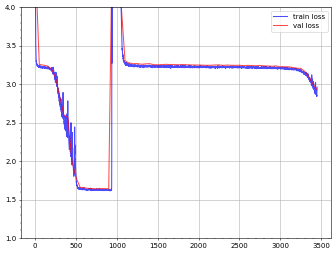

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

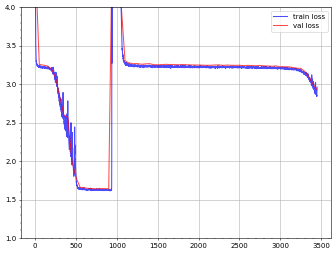

In [40]:
# training!
model = DSMTPTransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps, n_future_tokens=3)

# DeepSeek MTP Shared

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import copy

# targets: [B, n_future_tokens, S]

class DSMTPTransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.n_future_tokens = n_future_tokens

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)

@torch.compiler.disable
def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # Reshape freqs_cis for broadcasting
    shape = [1] * (xq_.ndim - 2) + list(freqs_cis.shape)
    freqs_cis = freqs_cis.view(*shape)

    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        
        def causal(b, h, q_idx, kv_idx):
            return q_idx >= kv_idx
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])
        
        if T == self.seq_len:
             out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            wei = q @ k.transpose(-2,-1) * (self.head_size**-0.5)
            wei = wei.masked_fill(self.tril[:T, :T_k] == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)
            out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)

    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache

class DSMTPTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        
        # The main body of the model
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num - config.n_future_tokens)])
        # The prediction heads that branch off
        self.extra_heads = nn.ModuleList([Block(config) for _ in range(config.n_future_tokens)])
        self.projection_head = nn.ModuleList([nn.Linear(2 * config.embed_size, config.embed_size) for _ in range(config.n_future_tokens)])
        self.shared_rms_norm = RMSNorm(config.embed_size)

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads=True, use_custom_backward=True):
        B, n_future_tokens, T = idx.shape

        tok_embd = self.token_embedding_table(idx) # B, n_future_tokens, T, C
        # print(tok_embd.shape)
        x = tok_embd[:, 0, :, :]  
        
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])

        n_heads_to_use = self.config.n_future_tokens if return_all_heads else 1
        prediction_heads = list(self.extra_heads)

        latents = []
        for i, block in enumerate(prediction_heads[:n_heads_to_use]):
            # print(f"1. {x.shape = }")

            # print(f"2. {x.shape = }")
            if i > 0:
                x = self.shared_rms_norm(x)
                new_input = self.shared_rms_norm(tok_embd[:, i, :, :].detach())
                x = torch.cat((x, new_input), dim=-1) # B, S, 2
                # print(f"3. {x.shape = }")
                x = self.projection_head[i](x)
                # print(f"4. {x.shape = }")
            x, _ = block(x)

            # print(f"5. {x.shape = }")
            latents.append(x)
        x = torch.stack(latents, dim=-2)
        # print(f"{x.shape  = }")
        all_logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, V = all_logits.shape[0], all_logits.shape[1], all_logits.shape[-1]
            logits_flat = all_logits.view(B * T * n_heads_to_use, V)
            targets_flat = targets.reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)

        # print(f"{idx = }")
        # print(f"{targets = }")

        logits = all_logits if return_all_heads else all_logits[:, :, 0, :]
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.seq_len else idx[:, -self.config.seq_len:]
            logits, _ = self(idx_cond, return_all_heads=False)
            logits = logits[:, -1, :] / temperature if temperature > 0 else logits[:, -1, :]
            
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [42]:
# Test forward pass
n_future_tokens = 3
config = DSMTPTransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6,
    n_future_tokens=n_future_tokens
)
m = DSMTPTransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1, n_future_tokens)
logits, loss = m(xb, yb, return_all_heads=True)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

5169751

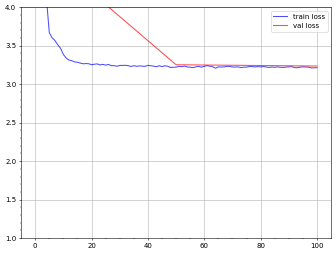

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# training!
model = DSMTPTransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps, n_future_tokens=3)